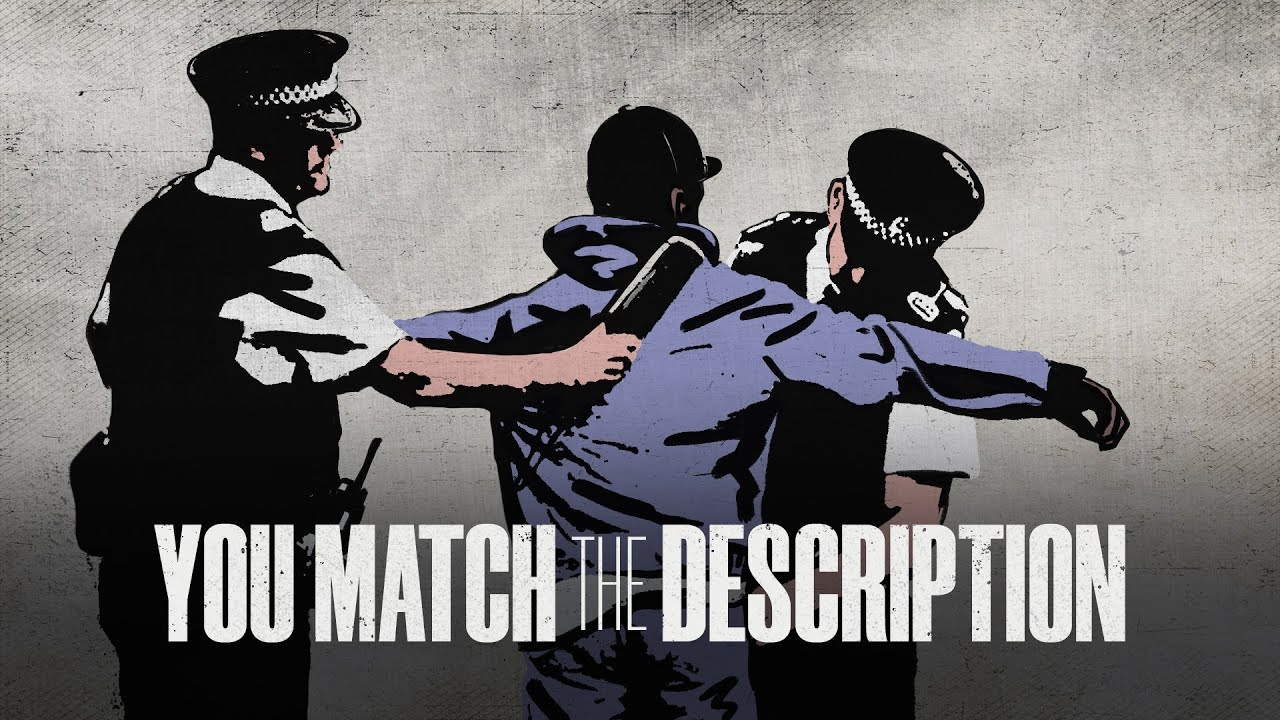

In [1]:
from IPython.display import Image
Image('./images/header.png')

Source: BBC

# Analysis of Stop and Search conducted by the Metropolitan Police from July 2017 to June 2020

### The following questions were the impetus for this research, and we explore each in turn: 

1. How common is it for a search to be performed on a vehicle, but not the occupant/driver? 
2. How much more frequently are males searched compared to females?
3. Which age group undergoes the most searches?
4. What is the ethnicity of the citizens who undergo the most searches?
5. What is the ethnicity of the officers who perform the most searches? 
6. Which piece of legislation do officers most commonly invoke to justify a search? 
7. What do officers most commonly claim they are looking for to justify a search? 
8. What is the most common outcome of a search?
9. At which part of the day are most searches perfomed? 
10. How do the number of searches vary by London borough?

The raw data can be acquired [here](data.police.uk/data).

### Import required packages

In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
pd.options.plotting.backend = "plotly"
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import glob
import re
from IPython.display import display, clear_output, IFrame
import requests
import json
import warnings
warnings.filterwarnings('ignore')

### Import individual CSV files and concat into one Data Frame

In [3]:
files = glob.glob('raw_data/*.csv')
temp_df = pd.concat([pd.read_csv(fp) for fp in files], ignore_index=True)

### Observe missing values and data types

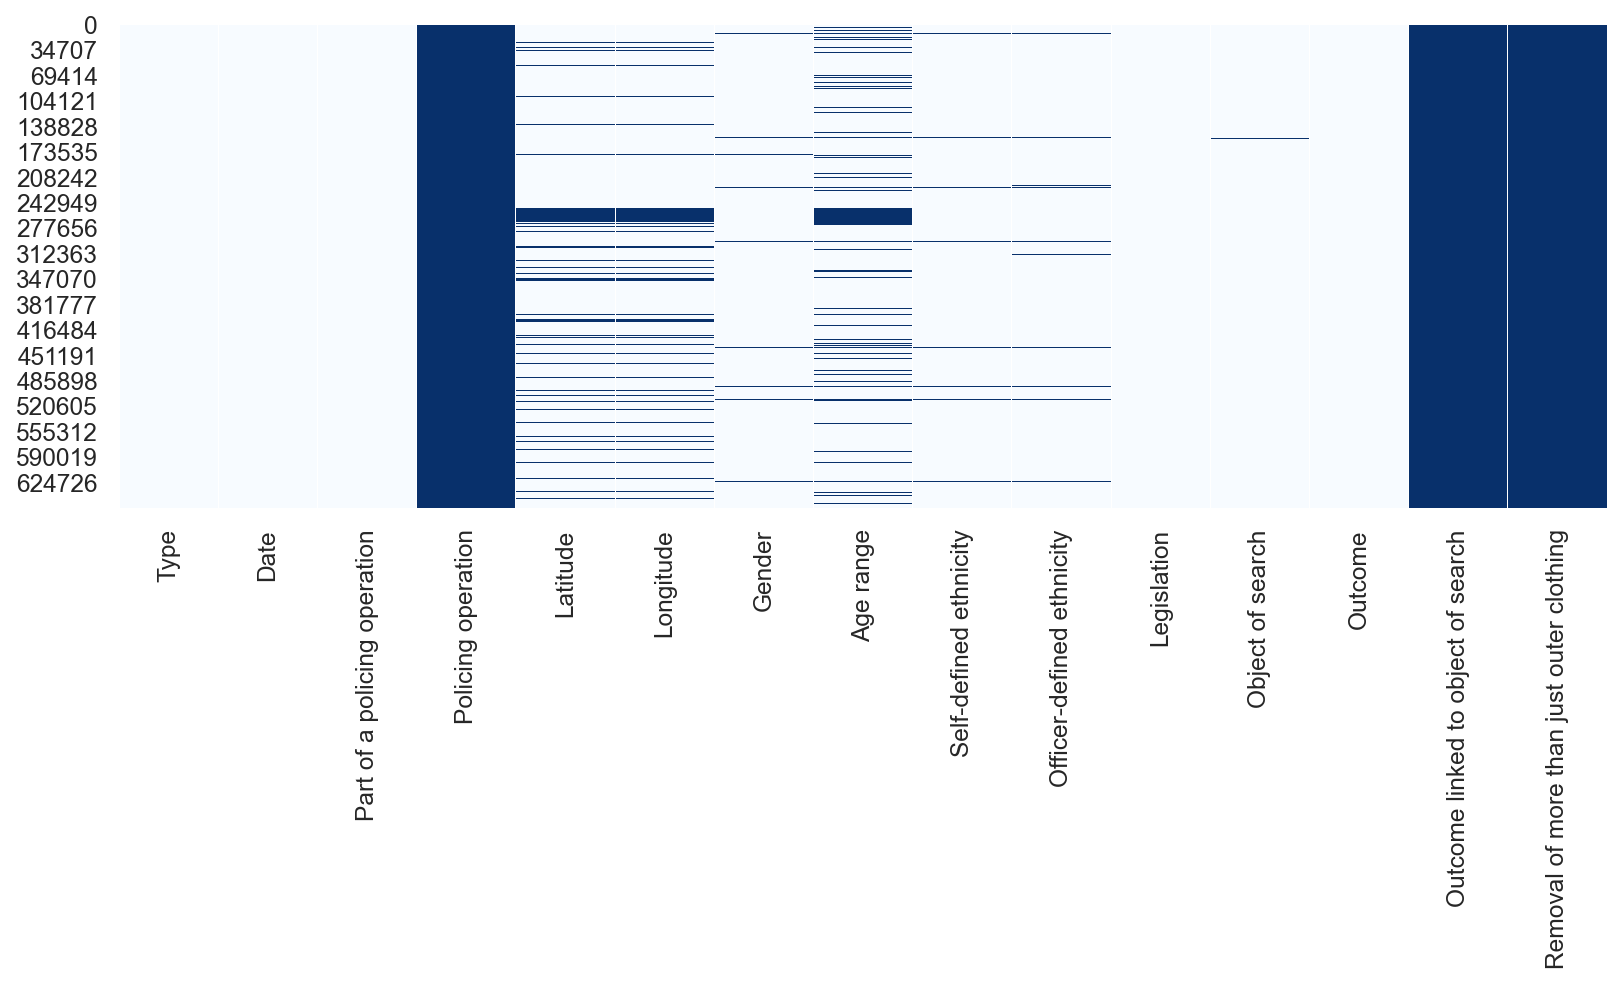

In [4]:
plt.figure(figsize=(12,4), dpi=160)
sns.heatmap(temp_df.isnull(), cmap='Blues', cbar=False)

### Drop columns that have either far too many missing values or the value is the same in all rows

In [5]:
temp_df.drop(['Policing operation', 'Outcome linked to object of search', 'Removal of more than just outer clothing', 'Part of a policing operation'], axis=1, inplace=True)

### Save to CSV

This CSV is intended to be a starting point for others to conduct their own analysis.

In [6]:
temp_df.to_csv('./data/met-police-stop-search-2017-07-2020-06.csv', index=False)

### Import new CSV

In [7]:
df = pd.read_csv('./data/met-police-stop-search-2017-07-2020-06.csv')

In [8]:
df.head()

,Type,Date,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome
0,Person search,2020-02-01T00:00:00+00:00,51.512098,-0.139407,Male,18-24,Black/African/Caribbean/Black British - African,Black,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,A no further action disposal
1,Person search,2020-02-01T00:00:00+00:00,51.378427,-0.102657,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Criminal Justice and Public Order Act 1994 (se...,Anything to threaten or harm anyone,A no further action disposal
2,Person search,2020-02-01T00:02:00+00:00,51.378427,-0.102657,Male,over 34,Asian/Asian British - Any other Asian background,Asian,Criminal Justice and Public Order Act 1994 (se...,Anything to threaten or harm anyone,A no further action disposal
3,Person search,2020-02-01T00:05:00+00:00,51.426626,-0.338871,Male,10-17,White - English/Welsh/Scottish/Northern Irish/...,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,Penalty Notice for Disorder
4,Person search,2020-02-01T00:05:00+00:00,51.496767,-0.096321,Male,18-24,Asian/Asian British - Any other Asian background,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution


### Transform column names, e.g. " Column Name " -> "column_name"

In [9]:
def clean_col_name(name):
	return " ".join(name.split()).replace(' ', '_').replace('-', '_').lower()

df.columns = list(map(clean_col_name,df.columns))
df.head(0)

,type,date,latitude,longitude,gender,age_range,self_defined_ethnicity,officer_defined_ethnicity,legislation,object_of_search,outcome


### Visualise null values

We will deal with these throughout the analysis 

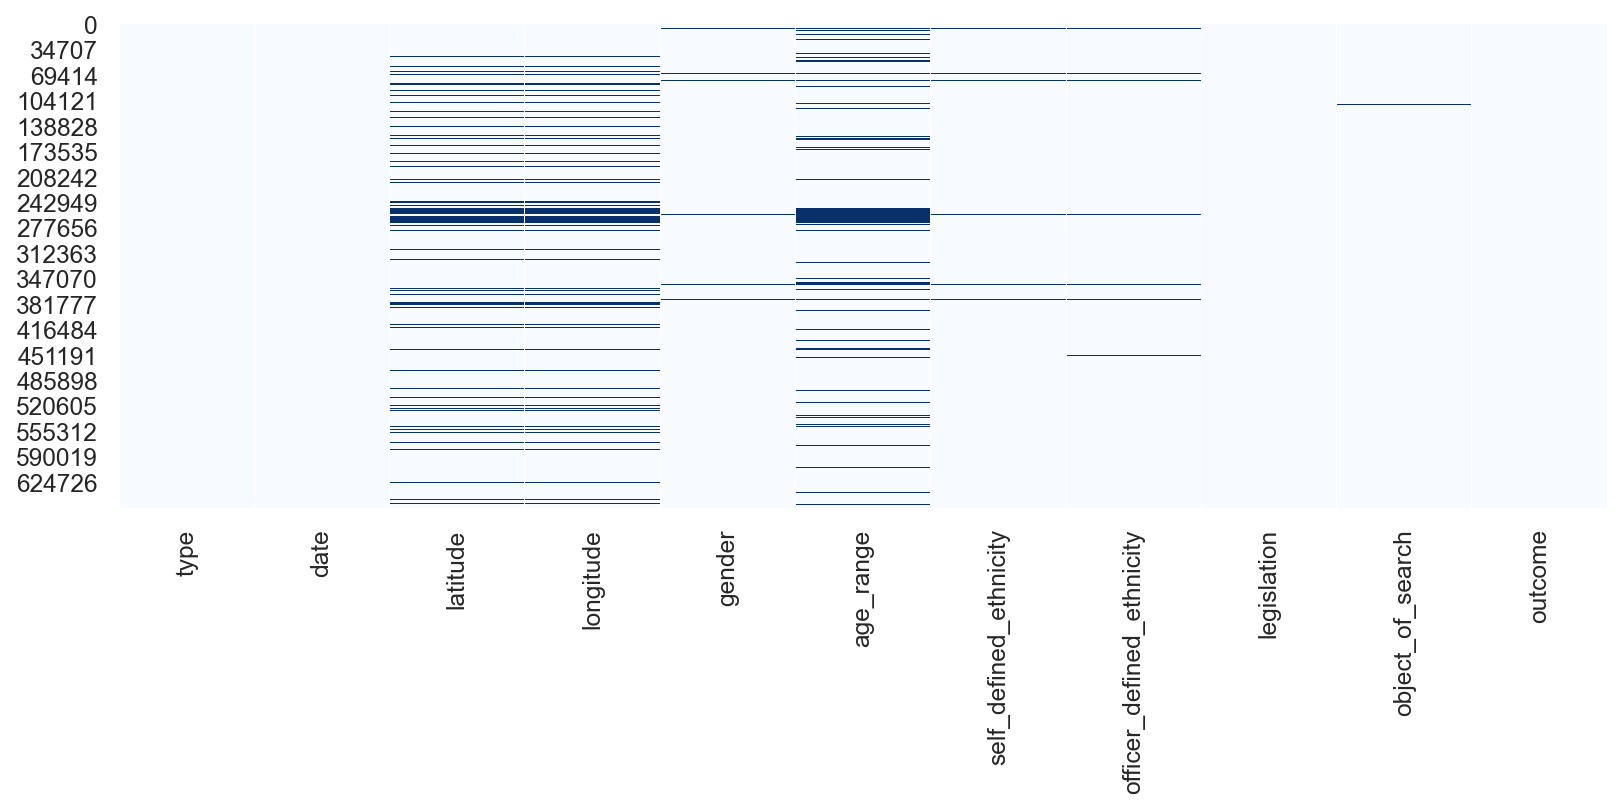

In [10]:
plt.figure(figsize=(12,4), dpi=160)
sns.heatmap(df.isnull(), cmap='Blues', cbar=False)

### Fill all null values with 'Unknown'

In [11]:
df.fillna('Unknown', inplace=True)

### Check there are no more null values in any column

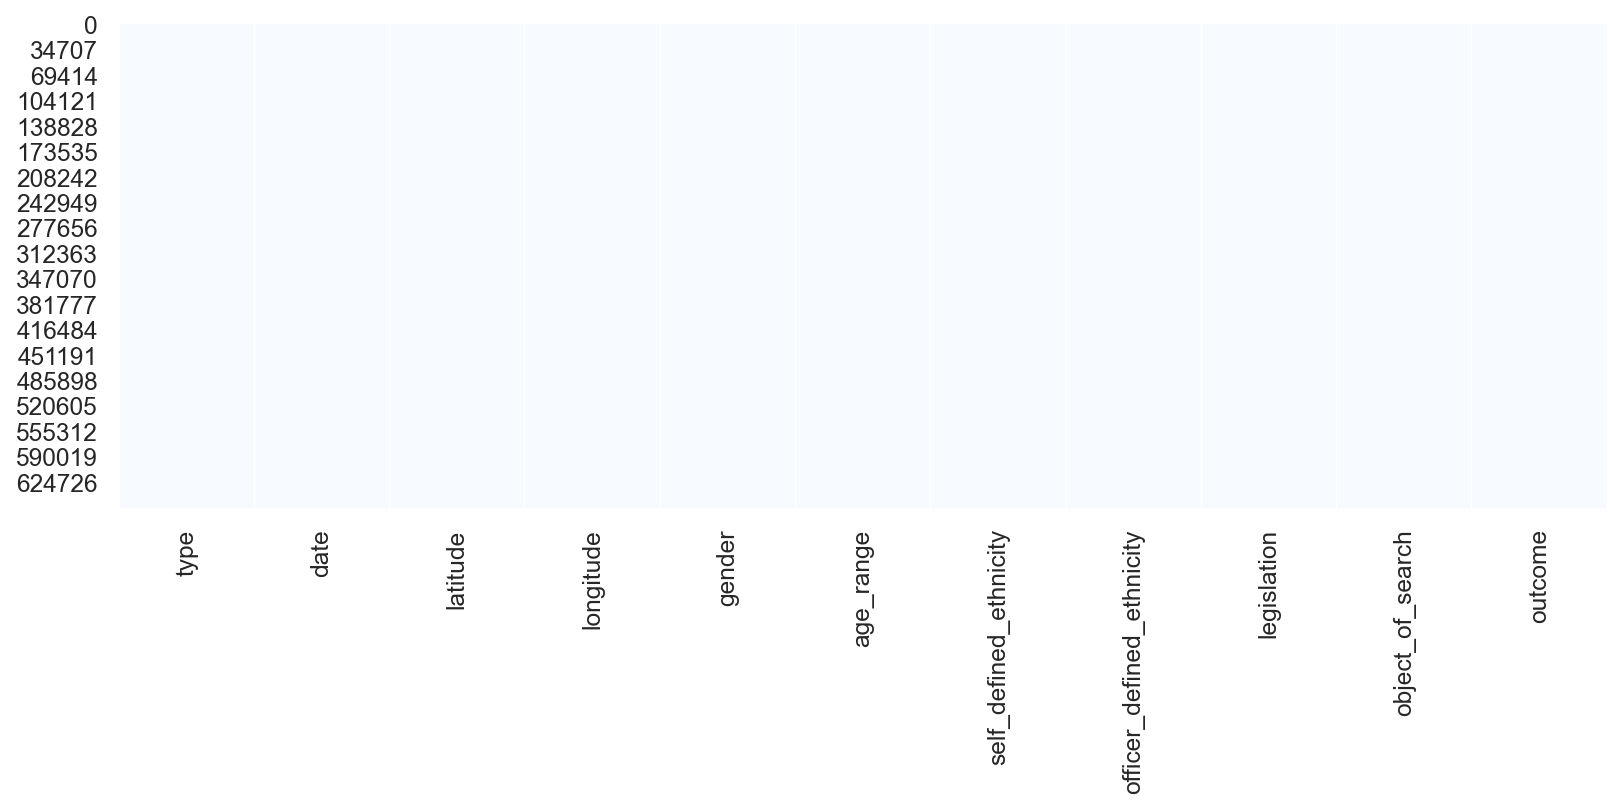

In [12]:
plt.figure(figsize=(12,4), dpi=160)
sns.heatmap(df.isnull(), cmap='Blues', cbar=False)

### Convert date column from type object to datetime

In [13]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659414 entries, 0 to 659413
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   type                       659414 non-null  object             
 1   date                       659414 non-null  datetime64[ns, UTC]
 2   latitude                   659414 non-null  object             
 3   longitude                  659414 non-null  object             
 4   gender                     659414 non-null  object             
 5   age_range                  659414 non-null  object             
 6   self_defined_ethnicity     659414 non-null  object             
 7   officer_defined_ethnicity  659414 non-null  object             
 8   legislation                659414 non-null  object             
 9   object_of_search           659414 non-null  object             
 10  outcome                    659414 non-null  object      

### Create year, month, and day columns

In [14]:
df['year'] = df['date'].apply(lambda x: x.year)
df['month'] = df['date'].apply(lambda x: x.month)
df['day'] = df['date'].apply(lambda x: x.day)
df['hour'] = df['date'].apply(lambda x: x.hour)

df.drop('date', axis=1, inplace=True) # We don't need the date column anymore

df.head(2)

,type,latitude,longitude,gender,age_range,self_defined_ethnicity,officer_defined_ethnicity,legislation,object_of_search,outcome,year,month,day,hour
0,Person search,51.5121,-0.139407,Male,18-24,Black/African/Caribbean/Black British - African,Black,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,A no further action disposal,2020,2,1,0
1,Person search,51.3784,-0.102657,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Criminal Justice and Public Order Act 1994 (se...,Anything to threaten or harm anyone,A no further action disposal,2020,2,1,0


### Create part of day column

In [15]:
def part_of_day(hour):
    if hour >= 6 and hour < 12:
        return 'Morning'
    elif hour >= 12 and hour < 18:
        return 'Afternoon'
    elif hour >= 17 and hour < 20:
        return 'Evening'
    else:
        return 'Night'

df['part_of_day'] = df['hour'].apply(part_of_day)

### View searched individual ethnicity categories

In [16]:
df['self_defined_ethnicity'].value_counts()

White - English/Welsh/Scottish/Northern Irish/British                                   124253
Other ethnic group - Not stated                                                         119897
Black/African/Caribbean/Black British - Any other Black/African/Caribbean background     85966
White - Any other White background                                                       76370
Black/African/Caribbean/Black British - African                                          62004
Asian/Asian British - Any other Asian background                                         43564
Black/African/Caribbean/Black British - Caribbean                                        42599
Asian/Asian British - Bangladeshi                                                        26128
Other ethnic group - Any other ethnic group                                              17240
Mixed/Multiple ethnic groups - Any other Mixed/Multiple ethnic background                12470
Asian/Asian British - Pakistani                   

### Simplify searched individual ethnicity categories

In [17]:
def cat_ethnicity(col_val):
    temp_list = col_val.replace('/', ' ').split(' ')
    if 'stated' in temp_list:
        return 'Not Stated'
    elif 'Mixed' in temp_list:
        if 'Black' in temp_list:
            return 'Black'
        elif 'Asian' in temp_list:
            return 'Asian'
        else:
            return 'Other'
    else: 
        return (col_val.split(' ')[0]).split('/')[0]
    
df['self_defined_ethnicity'] = df['self_defined_ethnicity'].apply(cat_ethnicity)

df['self_defined_ethnicity'].value_counts()

White         206095
Black         200866
Not Stated    119897
Asian          94469
Other          29710
Unknown         8377
Name: self_defined_ethnicity, dtype: int64

In [18]:
def cat_outcome(col_val):
    col_val_lower = (col_val.lower())
    if 'further' in col_val_lower:
        return 'NFA'
    elif 'caution' in col_val_lower:
        return 'Caution'
    elif 'warning' in col_val_lower:
        return 'Warning'
    elif 'summons' in col_val_lower:
        return 'Summons'
    elif 'penalty' in col_val_lower:
        return 'Fine'
    elif 'arrest' in col_val_lower:
        return 'Arrest'
    elif 'resolution' in col_val_lower:
        return 'Resolution'
    else:
        raise Exception('Value not accounted for')

df['outcome'] = df['outcome'].apply(cat_outcome)

In [19]:
df['legislation'].unique()

array(['Police and Criminal Evidence Act 1984 (section 1)',
       'Criminal Justice and Public Order Act 1994 (section 60)',
       'Misuse of Drugs Act 1971 (section 23)',
       'Firearms Act 1968 (section 47)'], dtype=object)

In [20]:
def transform_legislation(legislation):
    if legislation == 'Police and Criminal Evidence Act 1984 (section 1)':
        return 'PACE'
    elif legislation == 'Criminal Justice and Public Order Act 1994 (section 60)':
        return 'Public Order Act'
    elif legislation == 'Misuse of Drugs Act 1971 (section 23)':
        return 'Misuse of Drugs Act'
    else:
        return 'Firearms Act' 

df['legislation'] = df['legislation'].apply(transform_legislation)

### Define plotting function

In [21]:
def plot_value_count(question, col_name, dataframe, by_ethnicity=False, all_horizontal=False):        
    title = (" ".join(col_name.split('_'))).title()

    if by_ethnicity:
        palette = reversed(sns.color_palette("coolwarm", 3))
        ethnic_df = dataframe[(dataframe['self_defined_ethnicity'] == 'White') | (dataframe['self_defined_ethnicity'] == 'Black') | (dataframe['self_defined_ethnicity'] == 'Asian')]
        ethnic_df['occurance'] = 1
        grouped_ethnic_df = round(ethnic_df.groupby(['self_defined_ethnicity', col_name])['occurance'].count() / len(ethnic_df) * 100, 2).to_frame()
        sns.countplot(y=col_name, hue="self_defined_ethnicity", data=ethnic_df, palette=palette)
        plt.xlabel('')
        plt.ylabel('')
        plt.yticks(rotation=45)
        plt.title(title + ' by Ethnicity', fontsize=18)
        plt.legend(title='Self defined ethnicity')
        plt.savefig('./figures/' +col_name+ "_ethnicity.png", dpi=320)
        plt.show()
        grouped_ethnic_df.rename(columns={'occurance': '% of Total'}, inplace=True)
        display(grouped_ethnic_df)
    else:     
        value_counts = dataframe[col_name].value_counts()
        palette = reversed(sns.color_palette("coolwarm", len(value_counts)))
        if all_horizontal:
            sns.barplot(y=value_counts.index, x=value_counts, palette=palette)
            plt.title('Number of Searches per London borough', fontsize=11)
        else:
            sns.barplot(x=value_counts.index, y=value_counts, palette=palette)
            plt.title(title, fontsize=18)
        plt.xticks(rotation=45)
        plt.xlabel('')
        plt.ylabel('')
        plt.savefig('./figures/' +col_name+ ".png", dpi=320)
#         plt.suptitle(question, y=1.05)
        plt.show()
        display(pd.DataFrame(index=value_counts.index, data={'Count' : value_counts, '% of Total': (value_counts / len(dataframe)) * 100}).round(decimals=2))

### Define question list

In [22]:
questions = [
    ('How common is it for a search to be performed on a vehicle, but not the occupant/driver?', 'type'), 
    ('How much more frequently are males searched compared to females?', 'gender'),
    ('Which age group is searched most often?', 'age_range'),
    ('What is the ethnicity of citizens who are searched the most?', 'self_defined_ethnicity'),
    ('What is the ethnicity of officers who search the most?', 'officer_defined_ethnicity'),
    ('Which piece of legislation do officers most commonly invoke to justify a search?', 'legislation'),
    ('What do officers most commonly claim they are looking for to justify a search?', 'object_of_search'),
    ('What is the most common outcome of a search?', 'outcome'),
    ('At which part of the day are most searches perfomed?', 'part_of_day'),
]

### Loop through questions and plot results

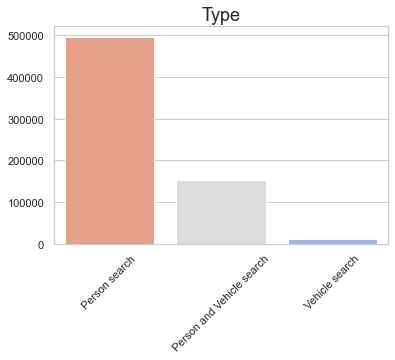

,Count,% of Total
Person search,496479,75.29
Person and Vehicle search,152592,23.14
Vehicle search,10343,1.57


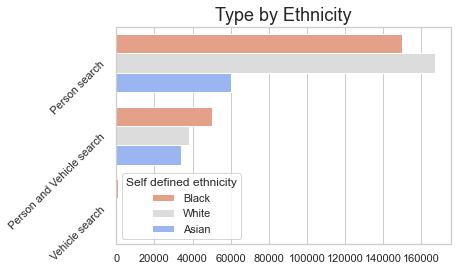

% of Total
self_defined_ethnicity type                                 
Asian                  Person and Vehicle search        6.80
                       Person search                   11.96
                       Vehicle search                   0.08
Black                  Person and Vehicle search       10.03
                       Person search                   29.90
                       Vehicle search                   0.12
White                  Person and Vehicle search        7.62
                       Person search                   33.38
                       Vehicle search                   0.10

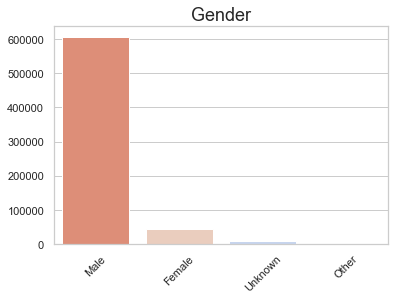

,Count,% of Total
Male,607725,92.16
Female,42758,6.48
Unknown,8585,1.30
Other,346,0.05


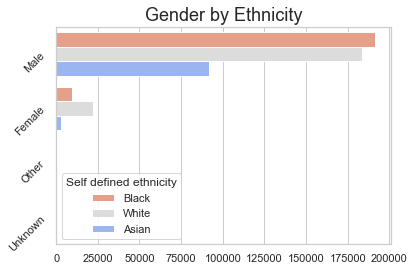

% of Total
self_defined_ethnicity gender             
Asian                  Female         0.56
                       Male          18.26
                       Other          0.01
                       Unknown        0.02
Black                  Female         1.84
                       Male          38.18
                       Other          0.01
                       Unknown        0.02
White                  Female         4.41
                       Male          36.65
                       Other          0.02
                       Unknown        0.03

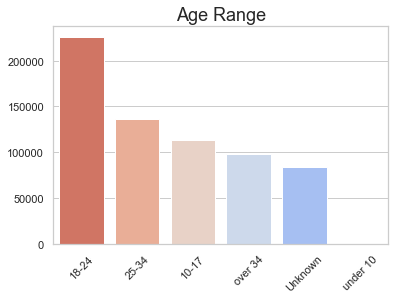

,Count,% of Total
18-24,226206,34.30
25-34,136857,20.75
10-17,113827,17.26
over 34,98207,14.89
Unknown,84206,12.77
under 10,111,0.02


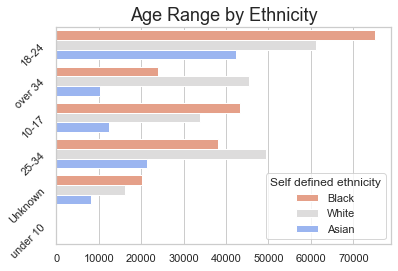

% of Total
self_defined_ethnicity age_range            
Asian                  10-17            2.47
                       18-24            8.46
                       25-34            4.24
                       Unknown          1.62
                       over 34          2.03
                       under 10         0.00
Black                  10-17            8.66
                       18-24           14.98
                       25-34            7.60
                       Unknown          4.01
                       over 34          4.81
                       under 10         0.01
White                  10-17            6.75
                       18-24           12.20
                       25-34            9.88
                       Unknown          3.23
                       over 34          9.05
                       under 10         0.01

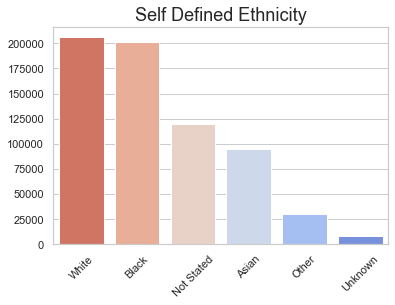

,Count,% of Total
White,206095,31.25
Black,200866,30.46
Not Stated,119897,18.18
Asian,94469,14.33
Other,29710,4.51
Unknown,8377,1.27


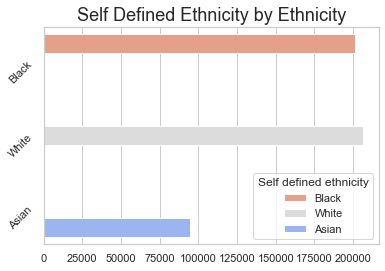

,,% of Total
self_defined_ethnicity,self_defined_ethnicity,
Asian,Asian,18.84
Black,Black,40.06
White,White,41.10


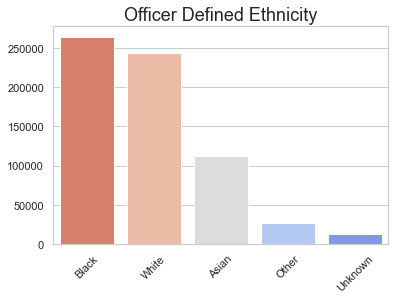

,Count,% of Total
Black,264615,40.13
White,244306,37.05
Asian,111738,16.95
Other,26192,3.97
Unknown,12563,1.91


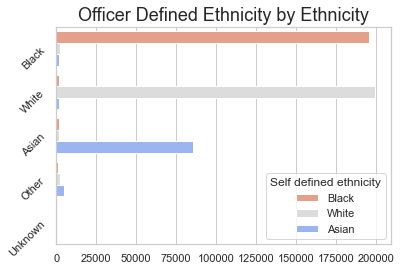

% of Total
self_defined_ethnicity officer_defined_ethnicity            
Asian                  Asian                           17.09
                       Black                            0.36
                       Other                            1.03
                       Unknown                          0.05
                       White                            0.32
Black                  Asian                            0.30
                       Black                           39.00
                       Other                            0.26
                       Unknown                          0.09
                       White                            0.40
White                  Asian                            0.29
                       Black                            0.48
                       Other                            0.46
                       Unknown                          0.12
                       White                           39.76

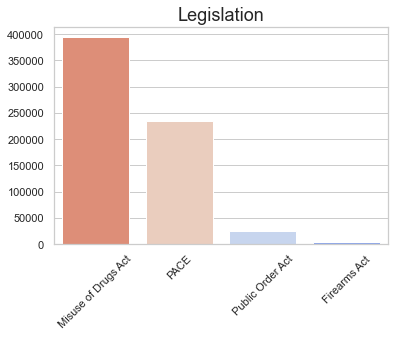

,Count,% of Total
Misuse of Drugs Act,394680,59.85
PACE,235223,35.67
Public Order Act,24766,3.76
Firearms Act,4745,0.72


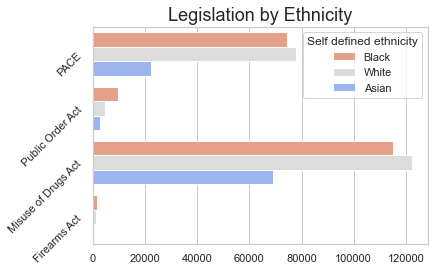

% of Total
self_defined_ethnicity legislation                    
Asian                  Firearms Act               0.12
                       Misuse of Drugs Act       13.74
                       PACE                       4.45
                       Public Order Act           0.54
Black                  Firearms Act               0.33
                       Misuse of Drugs Act       22.93
                       PACE                      14.88
                       Public Order Act           1.92
White                  Firearms Act               0.25
                       Misuse of Drugs Act       24.39
                       PACE                      15.52
                       Public Order Act           0.94

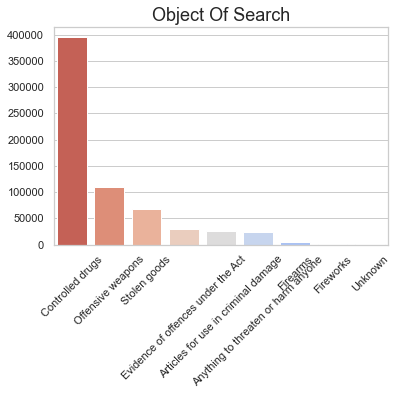

,Count,% of Total
Controlled drugs,394680,59.85
Offensive weapons,109204,16.56
Stolen goods,66960,10.15
Evidence of offences under the Act,29709,4.51
Articles for use in criminal damage,26001,3.94
Anything to threaten or harm anyone,24766,3.76
Firearms,4745,0.72
Fireworks,1687,0.26
Unknown,1662,0.25


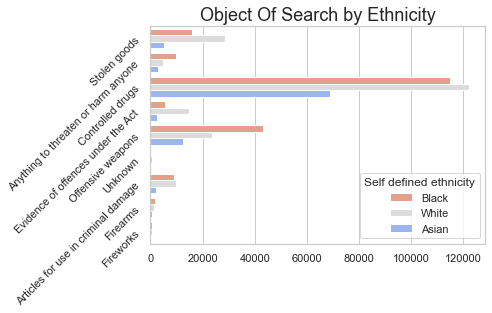

% of Total
self_defined_ethnicity object_of_search                               
Asian                  Anything to threaten or harm anyone        0.54
                       Articles for use in criminal damage        0.44
                       Controlled drugs                          13.74
                       Evidence of offences under the Act         0.47
                       Firearms                                   0.12
                       Fireworks                                  0.03
                       Offensive weapons                          2.47
                       Stolen goods                               1.00
                       Unknown                                    0.04
Black                  Anything to threaten or harm anyone        1.92
                       Articles for use in criminal damage        1.76
                       Controlled drugs                          22.93
                       Evidence of offences under the Act         1.13
                       Firearms                                   0.33
                       Fireworks                                  0.09
                       Offensive weapons                          8.62
                       Stolen goods                               3.21
                       Unknown                                    0.07
White                  Anything to threaten or harm anyone        0.94
                       Articles for use in criminal damage        1.95
                       Controlled drugs                          24.39
                       Evidence of offences under the Act         2.92
                       Firearms                                   0.25
                       Fireworks                                  0.11
                       Offensive weapons                          4.73
                       Stolen goods                               5.67
                       Unknown                                    0.14

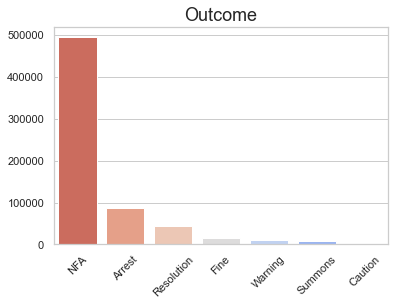

,Count,% of Total
NFA,494875,75.05
Arrest,87938,13.34
Resolution,44789,6.79
Fine,14501,2.20
Warning,9260,1.40
Summons,7599,1.15
Caution,452,0.07


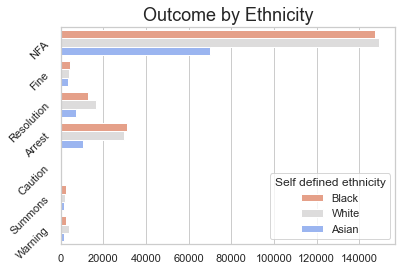

% of Total
self_defined_ethnicity outcome               
Asian                  Arrest            2.13
                       Caution           0.01
                       Fine              0.69
                       NFA              13.96
                       Resolution        1.44
                       Summons           0.27
                       Warning           0.32
Black                  Arrest            6.17
                       Caution           0.02
                       Fine              0.88
                       NFA              29.39
                       Resolution        2.55
                       Summons           0.50
                       Warning           0.54
White                  Arrest            5.94
                       Caution           0.04
                       Fine              0.82
                       NFA              29.80
                       Resolution        3.31
                       Summons           0.43
                       Warning           0.75

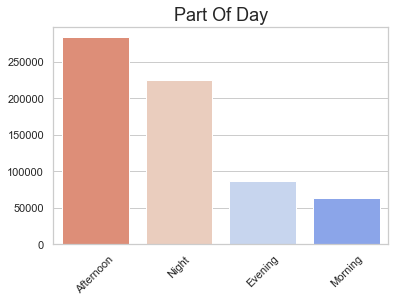

,Count,% of Total
Afternoon,283914,43.06
Night,225423,34.19
Evening,86285,13.09
Morning,63792,9.67


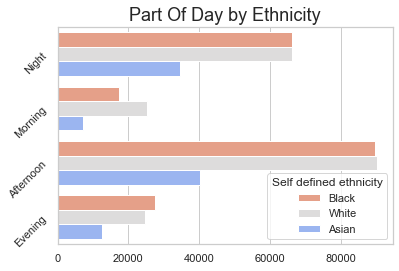

% of Total
self_defined_ethnicity part_of_day            
Asian                  Afternoon          8.02
                       Evening            2.50
                       Morning            1.45
                       Night              6.87
Black                  Afternoon         17.87
                       Evening            5.49
                       Morning            3.47
                       Night             13.23
White                  Afternoon         17.97
                       Evening            4.92
                       Morning            5.03
                       Night             13.19

In [23]:
for question in questions:
    print('\n\n\n\n\n')
    plot_value_count(question[0], question[1], df)
    plot_value_count(question[0], question[1], df, by_ethnicity=True)

### Grab rows that have both a latitude and longitude value

In [24]:
geo_df = df[(df['latitude'] != 'Unknown') & (df['longitude'] != 'Unknown')]
len(geo_df)

576590

### Map lat lon coordinates to london boroughs
This function can take over an hour to complete, so it's advisable to load in the dictionary in the following step instead.

In [25]:
# geo_df['latlon'] = geo_df.apply(lambda x: (x['latitude'], x['longitude']), axis=1)
# unique_combinations = geo_df['latlon'].unique()
# lat_lon_dict = {}

# def fill_lat_lon_dict(combs):
#     for comb in combs:
#         try:
#             url = f'http://api.postcodes.io/postcodes?lon={comb[1]}&lat={comb[0]}'
#             response = requests.get(url)
#             json_data = json.loads(response.text)
#             dict_key = lat_lon_dict[str(comb[0])+','+str(comb[1])]
#             dict_key = json_data['result'][0]['admin_district']
#         except:
#             dict_key = 'Unknown'
            
# fill_lat_lon_dict(unique_combinations)

# with open('./lat_lon_dict.json', 'w') as fp:
#     json.dump(lat_lon_dict, fp)

### Load dict

In [26]:
with open('./lat_lon_dict.json', 'r') as fp:
    lat_lon_dict = json.load(fp)

### Add borough column to data frame

In [27]:
geo_df['borough'] = geo_df.apply(lambda x: lat_lon_dict[str(x['latitude']) + "," + str(x['longitude'])], axis=1)

### Drop rows with 'Unknown' in borough column

In [28]:
geo_df = geo_df[geo_df['borough'] != 'Unknown']

### We no longer need the latitude and longitude columns

In [29]:
geo_df.drop(['latitude', 'longitude'], axis=1, inplace=True)

### Save data frame containing borough column

In [30]:
geo_df.to_csv('./data/geospatial-met-police-stop-search-2017-07-2020-06.csv')

### Remove rows where the borough value does not belong to London

In [31]:
geo_df = geo_df[geo_df['borough'].isin(geo_df['borough'].value_counts()[:32].index)]

## How do the number of searches vary by London borough? 

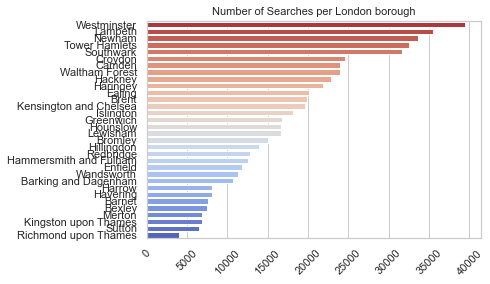

,Count,% of Total
Westminster,39529,7.03
Lambeth,35451,6.31
Newham,33593,5.98
Tower Hamlets,32581,5.80
Southwark,31669,5.63
Croydon,24591,4.38
Camden,24018,4.27
Waltham Forest,23994,4.27
Hackney,22819,4.06
Haringey,21887,3.89


In [32]:
plot_value_count('', 'borough', geo_df, all_horizontal=True)

## How do the number of searches vary by London borough? (part 2)

This choropleth map was built in Plotly's Chart Studio. 

In [33]:
IFrame('https://plotly.com/~rosshaden/1.embed', width=1000, height=600)